<div style="text-align:center">
    <h1>
        Continuous observation spaces
    </h1>
</div>

<br><br>

<div style="text-align:center">
    We will learn how to adapt tabular methods to continuous state spaces. We will do it with two methods: state aggregation and tile coding.
</div>


## Import the necessary software libraries:

In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm

from envs import Maze
from utils import plot_policy, plot_tabular_cost_to_go, test_agent, plot_stats, seed_everything

## Implement state aggregation

<br><br>

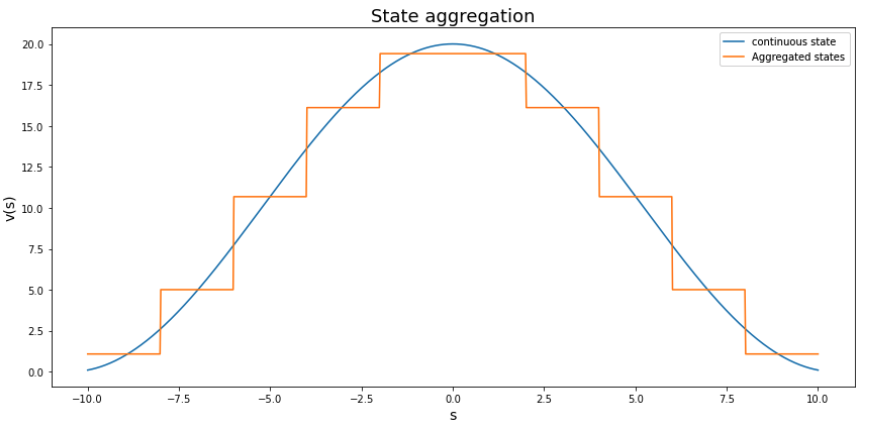

### Create the environment

In [2]:
env = gym.make('MountainCar-v0')
seed_everything(env)

### Create the state aggregation wrapper

In [3]:
class StateAggregationEnv(gym.ObservationWrapper):
    
    def __init__(self, env, bins, low, high):
        super().__init__(env)
        self.buckets = [np.linspace(j,k, l-1) for j,k,l in zip(low, high, bins)]
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist())
        
    def observation(self, obs):
        indices = tuple(np.digitize(i, b) for i,b in zip(obs, self.buckets))
        return indices

In [4]:
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregationEnv(env, bins=bins, low=low, high=high)

In [5]:
saenv.buckets

[array([-1.20000005, -1.10000004, -1.00000004, -0.90000004, -0.80000003,
        -0.70000003, -0.60000002, -0.50000002, -0.40000002, -0.30000001,
        -0.20000001, -0.1       ,  0.        ,  0.1       ,  0.20000001,
         0.30000001,  0.40000002,  0.50000002,  0.60000002]),
 array([-0.07      , -0.06222222, -0.05444444, -0.04666667, -0.03888889,
        -0.03111111, -0.02333333, -0.01555556, -0.00777778,  0.        ,
         0.00777778,  0.01555556,  0.02333333,  0.03111111,  0.03888889,
         0.04666667,  0.05444444,  0.06222222,  0.07      ])]

### Compare the original environment to the one with aggregated states

In [6]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

Modified observation space: MultiDiscrete([20 20]), 
Sample state: [6 8]


In [7]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [-0.52654195 -0.0021926 ]


### Create the $Q(s,a)$ value table

In [8]:
action_values = np.zeros((20,20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [9]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

### Test the SARSA algorithm on the modified environment

In [10]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = saenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = saenv.step(action)
            next_action = policy(next_state, epsilon)
            
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [11]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

100%|█████████████████████████████████████| 20000/20000 [03:55<00:00, 84.96it/s]


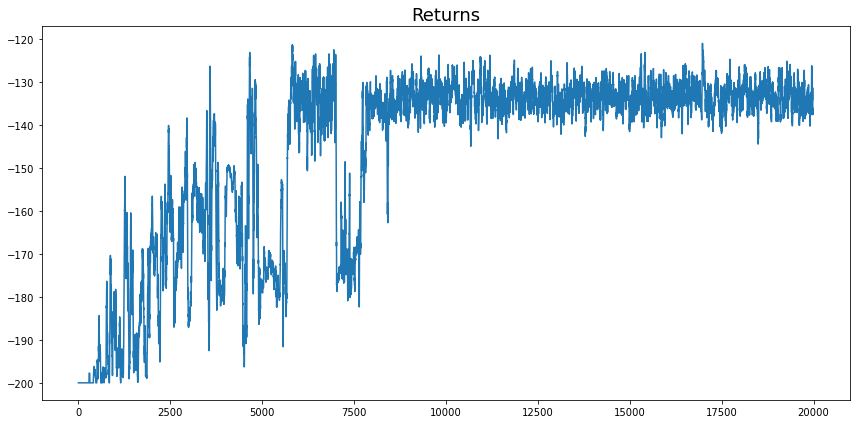

In [12]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

2022-08-25 07:41:08.624 python[1548:45857] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f90a1778d20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-08-25 07:41:08.625 python[1548:45857] Warning: Expected min height of view: (<NSButton: 0x7f90a178dc80>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-08-25 07:41:08.627 python[1548:45857] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f90a178e140>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-08-25 07:41:08.628 python[1548:45857] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f90a178f0b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


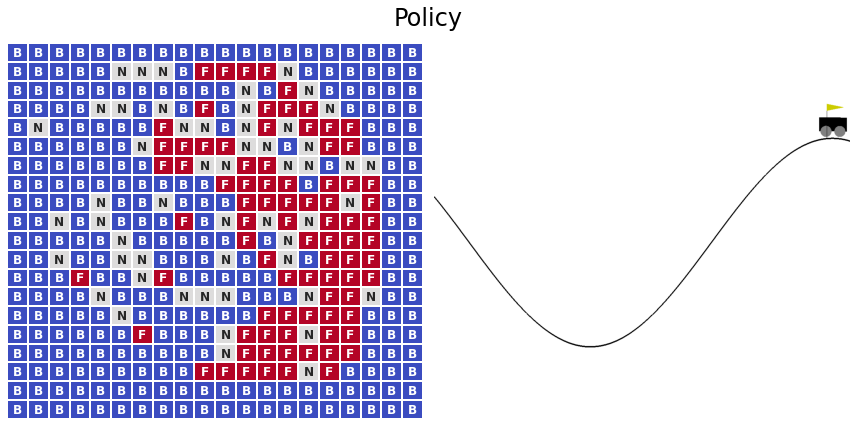

In [13]:
plot_policy(action_values, env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

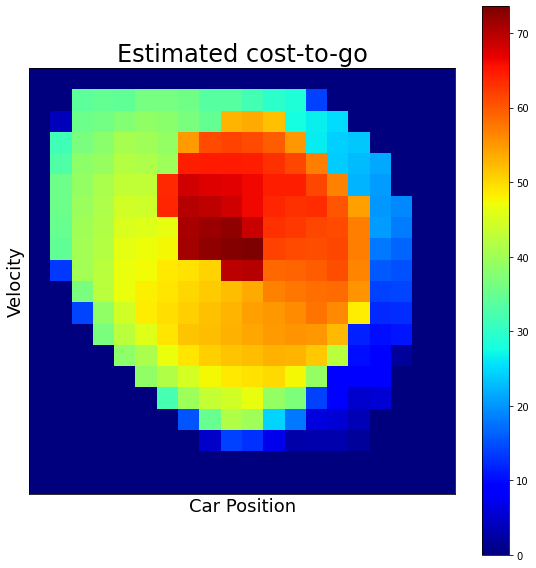

In [14]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

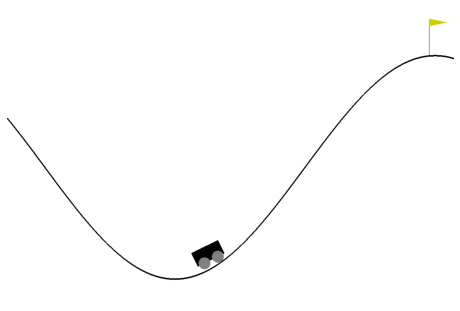

In [ ]:
test_agent(saenv, policy, 10)

<br><br><br><br>

## Implement Tile Coding

<br><br>

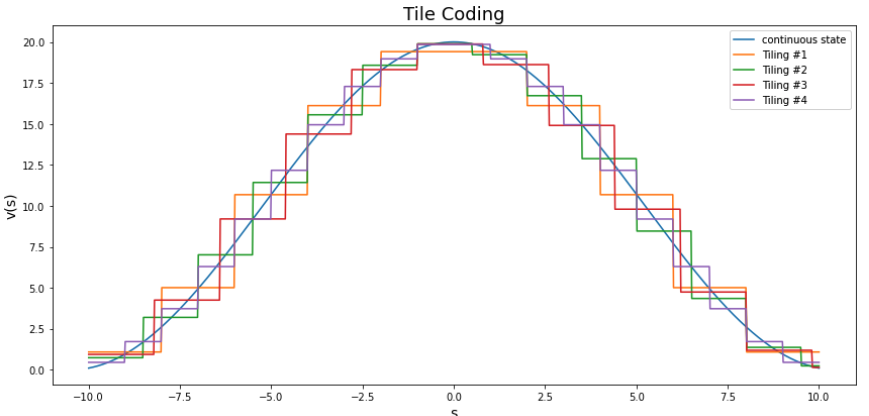

### Create the environment

In [ ]:
env = gym.make('MountainCar-v0')
seed_everything(env)

### Create the Tile Coding wrapper

In [ ]:
class TileCodingEnv(gym.ObservationWrapper):
    
    def __init__(self, env, bins, low, high, n=4):
        super().__init__(env)
        self.tilings = self._create_tilings(bins, high, low, n)
#         self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist())
        
    def observation(self, obs):
        indices = []
        for t in self.tilings:
            tiling_indices = tuple(np.digitize(i, b) for i,b in zip(obs, t))
            indices.append(tiling_indices)
        return indices
    
    def _create_tilings(self, bins, high, low, n):
        displacement_vector = np.arange(1,2*len(bins),2)
        tilings = []
        for i in range(1, n + 1):
            low_i = low - random.random() * .2 * low
            high_i = high + random.random() * .2 * high
            segment_sizes = (high_i - low_i) / bins
            displacements = displacement_vector * i % n
            displacements = displacements * (segment_sizes / n)
            low_i += displacements
            high_i += displacements
            buckets_i = [np.linspace(j,k, l-1) for j,k,l in zip(low_i, high_i, bins)]
            tilings.append(buckets_i)
        return tilings


In [ ]:
tilings = 4
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

### Compare the original environment to the one with aggregated states

In [ ]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

In [ ]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

### Create the $Q(s,a)$ value table

In [ ]:
action_values = np.zeros((4, 20, 20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [ ]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)
        
        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av == av.max()))

### Test the SARSA algorithm on the modified environment

In [ ]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = tcenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)
            
            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [ ]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

In [ ]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

In [ ]:
plot_policy(action_values.mean(axis=0), env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [ ]:
plot_tabular_cost_to_go(action_values.mean(axis=0), \
                        xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

In [ ]:
test_agent(tcenv, policy, 2)